<a href="https://colab.research.google.com/github/Tecnologias-Emergentes-Equipo2/ProyectoFinal/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Clasificación de Tumores Cerebrales Utilizando CNNs

## 1. Exploración de los Datos

Se monta el drive de Google y se crea un link simbólico a la carpeta que contiene los datos que se usarán para entrenar y probar el modelo.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/Shareddrives/Tecnologías\ Emergentes/Proyecto\ Final /proyecto
!ls /proyecto

 data  'Proyecto Final'   ProyectoFinal.ipynb


Función auxiliar que sirve para mostrar las imágenes en la Notebook.

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

Se importa al ambiente virtual de Google el archivo zip que contiene los datos y se infla para utilizar los archivos.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
!cp /proyecto/data/archive.zip ./
!unzip archive.zip -d data/

Archive:  archive.zip
  inflating: data/Testing/glioma_tumor/image(1).jpg  
  inflating: data/Testing/glioma_tumor/image(10).jpg  
  inflating: data/Testing/glioma_tumor/image(100).jpg  
  inflating: data/Testing/glioma_tumor/image(11).jpg  
  inflating: data/Testing/glioma_tumor/image(12).jpg  
  inflating: data/Testing/glioma_tumor/image(13).jpg  
  inflating: data/Testing/glioma_tumor/image(14).jpg  
  inflating: data/Testing/glioma_tumor/image(15).jpg  
  inflating: data/Testing/glioma_tumor/image(16).jpg  
  inflating: data/Testing/glioma_tumor/image(17).jpg  
  inflating: data/Testing/glioma_tumor/image(18).jpg  
  inflating: data/Testing/glioma_tumor/image(19).jpg  
  inflating: data/Testing/glioma_tumor/image(2).jpg  
  inflating: data/Testing/glioma_tumor/image(20).jpg  
  inflating: data/Testing/glioma_tumor/image(21).jpg  
  inflating: data/Testing/glioma_tumor/image(22).jpg  
  inflating: data/Testing/glioma_tumor/image(23).jpg  
  inflating: data/Testing/glioma_tumor/image

Ejemplo de una imágen del dataset:

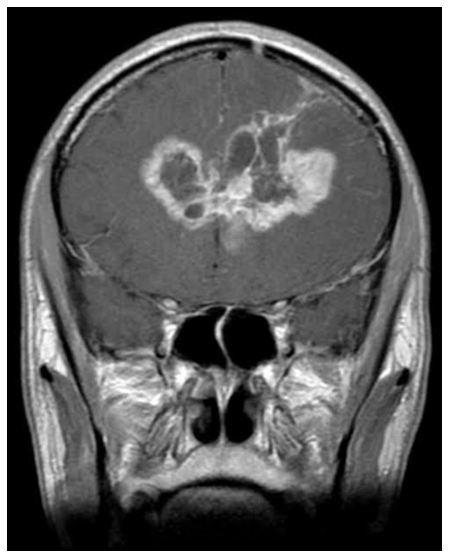

In [ ]:
imShow('data/Testing/glioma_tumor/image(1).jpg')

Se crea una carpeta para el set de validación, dividida en subcarpetas por cada tipo de tumor que contiene el dataset.

In [ ]:
!mkdir data/Validation/
%cd data/Validation
!mkdir glioma_tumor meningioma_tumor no_tumor pituitary_tumor
%cd ../
!ls Validation

/content/data/Validation
/content/data
glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


Se crean listas que contienen las direcciones a las imágenes del set de entrenamiento para dividirlo en set de entrenamiento y validación.

In [ ]:
names = sorted( [fldr for fldr in os.listdir('Training')] )
folders = sorted( [os.path.join('Training', fldr) for fldr in os.listdir('Training')] )
vals = dict()

for i in range(len(folders)):
  temp = sorted( [os.path.join(folders[i], img) for img in os.listdir(folders[i])] )
  _, vals[names[i]] = train_test_split(temp, test_size=0.5, random_state=1110)

print("Ejemplo de archivos de validación:")
vals[names[0]][:3]

Ejemplo de archivos de validación:


['Training/glioma_tumor/gg (178).jpg',
 'Training/glioma_tumor/gg (502).jpg',
 'Training/glioma_tumor/gg (258).jpg']

Se mueven las imágenes que están contenidas en cada una de las listas para cada tumor a su equivalente dentro de la carpeta de validación.

In [ ]:
for folder, archivos in vals.items():
  for archivo in archivos:
    try:
      shutil.move(archivo, ''.join(['Validation/', folder, '/']))
    except:
      print(archivo)
      assert False

Cabe mencionar que el dataset cuenta con una cantidad dispareja de imágenes para cada clase, siendo la clase de `no_tumor` aproximadamente la mitad de grande que las demás clases, por lo que se ha optado por removerse la categoría de no tumor del dataset y del enfoque del proyecto, que es la clasificación de diferentes tipos de tumor.

In [ ]:
%cd ../
!ls data/Validation/no_tumor | wc -l

/content
198


In [ ]:
!ls data/Validation/meningioma_tumor | wc -l

411


In [ ]:
!rm -R data/Training/no_tumor/ data/Validation/no_tumor/ data/Testing/no_tumor/
!ls data/Testing/

glioma_tumor  meningioma_tumor	pituitary_tumor


In [ ]:
!ls data/

Testing  Training  Validation


## 2. Arquitectura ResNet

In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
img_height,img_width = (224,224)
batch_size = 32

train_data_dir = "data/Training"
valid_data_dir = "data/Validation"
test_data_dir = "data/Testing"


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode ='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 743 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 115 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
base_model = ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator,epochs=10)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
24/24 [==============================] - 18s 526ms/step - loss: 2.3787 - accuracy: 0.5410
Epoch 2/10
24/24 [==============================] - 13s 525ms/step - loss: 0.4599 - accuracy: 0.8156
Epoch 3/10
24/24 [==============================] - 13s 528ms/step - loss: 0.3506 - accuracy: 0.8452
Epoch 4/10
24/24 [==============================] - 13s 524ms/step - loss: 0.2815 - accuracy: 0.8896
Epoch 5/10
24/24 [==============================] - 13s 527ms/step - loss: 0.2391 - accuracy: 0.9044
Epoch 6/10
24/24 [==============================] - 13s 529ms/step - loss: 0.2542 - accuracy: 0.9071
Epoch 7/10
24/24 [==============================] - 13s 524ms/step - loss: 0.2196 - accuracy: 0.9287
Epoch 8/10
24/24 [==============================] - 13s 527ms/step - loss: 0.1990 - accuracy: 0.9246
Epoch 9/10
24/24 [==============================] - 13s 527ms/step - loss: 0.1616 - accuracy: 0.9475
Epoch 10/10
24/24 [=======

In [ ]:
model.save('data/Modelo.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
test_loss,test_acc =model.evaluate(test_generator,verbose=2)
print('\nTest accuracy:',test_acc)

115/115 - 5s - loss: 1.3450 - accuracy: 0.6261 - 5s/epoch - 43ms/step

Test accuracy: 0.626086950302124


In [ ]:
import pandas as pd
import seaborn as sn
import tensorflow as tf


predicted class ['meningioma_tumor', 'glioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'pituitary_tumor', 'pituitary_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'glioma_

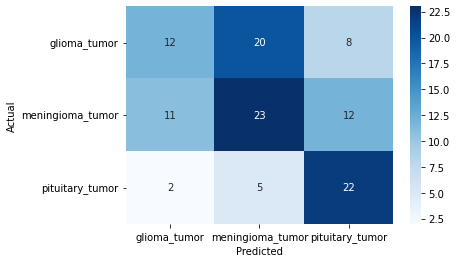

Test accuracy: 49.56521739130435


In [ ]:
model = tf.keras.models.load_model('data/Modelo.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test =test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class =[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
print('predicted class',predicted_class)
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]
print('actual class',actual_class)


out_df  = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt = 'd')
plt.show()
print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)
x,y = test_generator.next()

Found 115 images belonging to 3 classes.


In [ ]:
base_model = ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator,epochs=8)

Epoch 1/8
24/24 [==============================] - 16s 523ms/step - loss: 1.8253 - accuracy: 0.6339
Epoch 2/8
24/24 [==============================] - 13s 522ms/step - loss: 0.4455 - accuracy: 0.8264
Epoch 3/8
24/24 [==============================] - 13s 520ms/step - loss: 0.2887 - accuracy: 0.8816
Epoch 4/8
24/24 [==============================] - 13s 530ms/step - loss: 0.2546 - accuracy: 0.9139
Epoch 5/8
24/24 [==============================] - 13s 528ms/step - loss: 0.3242 - accuracy: 0.8802
Epoch 6/8
24/24 [==============================] - 13s 525ms/step - loss: 0.1873 - accuracy: 0.9435
Epoch 7/8
24/24 [==============================] - 13s 527ms/step - loss: 0.2514 - accuracy: 0.9071
Epoch 8/8
24/24 [==============================] - 13s 525ms/step - loss: 0.2150 - accuracy: 0.9112


In [ ]:
print('\nTest accuracy:',test_acc)

115/115 - 4s - loss: 2.0488 - accuracy: 0.5130 - 4s/epoch - 38ms/step

Test accuracy: 0.5130434632301331


In [ ]:
model.save('data/Modelo_iter_2.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Predicted class ['pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', '

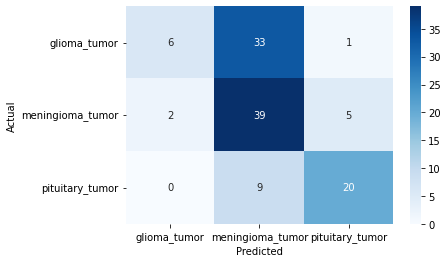

Test accuracy: 56.52173913043478


In [ ]:
model = tf.keras.models.load_model('data/Modelo_iter_2.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test =test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class =[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
print('Predicted class',predicted_class)
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

print('Actual class',actual_class)

out_df  = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt = 'd')
plt.show()
print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

##3. Arquitectura  AlexNet

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix,accuracy_score

In [ ]:
fpath = "data/Training"
paths =["data/Training","data/Testing",'data/Validation']
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:4]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'] 

No. of categories =  3


In [ ]:
def load_images_and_labels(categories,paths):
    img_lst=[]
    labels=[]
    for path in paths:
      for index, category in enumerate(categories):
          for image_name in os.listdir(path+"/"+category):
              img = cv2.imread(path+"/"+category+"/"+image_name)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              
              img_array = Image.fromarray(img, 'RGB')
              
              #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
              resized_img = img_array.resize((227, 227))
              
              img_lst.append(np.array(resized_img))
              
              labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories,paths)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(labels)
print(type(images),type(labels))

No. of images loaded =  2764 
No. of labels loaded =  2764
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2764, 227, 227, 3) 
Labels shape =  (2764,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


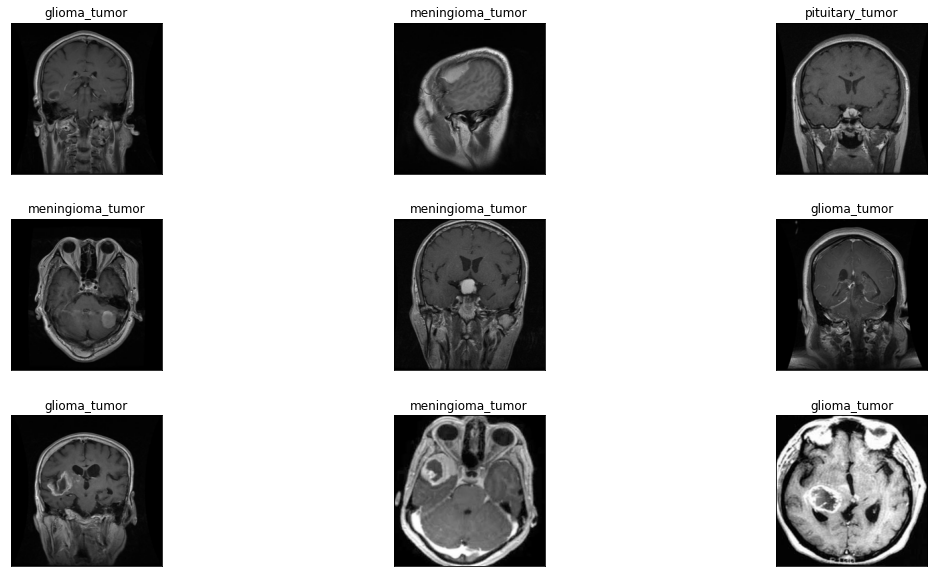

In [ ]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('{}'.format(categories[labels[r[0]]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [ ]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 2761 2762 2763]

'n' values after shuffling =  [1988 1216 1385 ... 1130 1294  860]


In [ ]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (2764, 227, 227, 3) 
Labels shape after shuffling =  (2764,)


In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2764, 227, 227, 3)


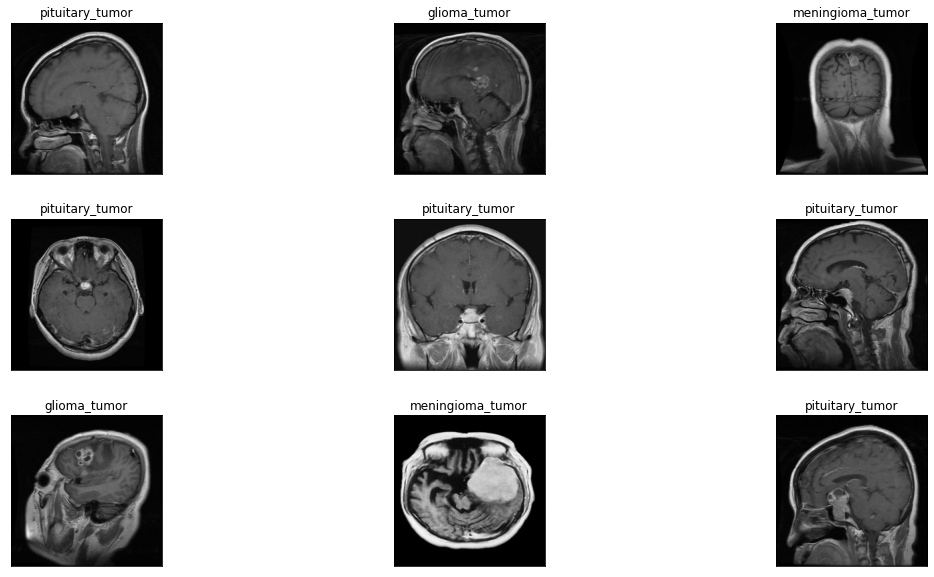

(2764, 227, 227, 3)


In [ ]:
display_rand_images(images, labels)
print(images.shape)

In [ ]:


model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))

model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_46 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                      

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.19, random_state = random_seed,shuffle=True)


In [ ]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
70/70 [==============================] - 8s 90ms/step - loss: 1.7325 - accuracy: 0.6461
Epoch 2/10
70/70 [==============================] - 5s 75ms/step - loss: 0.9008 - accuracy: 0.7466
Epoch 3/10
70/70 [==============================] - 5s 75ms/step - loss: 0.6969 - accuracy: 0.7735
Epoch 4/10
70/70 [==============================] - 5s 74ms/step - loss: 0.5388 - accuracy: 0.8150
Epoch 5/10
70/70 [==============================] - 5s 76ms/step - loss: 0.4549 - accuracy: 0.8329
Epoch 6/10
70/70 [==============================] - 5s 75ms/step - loss: 0.3585 - accuracy: 0.8718
Epoch 7/10
70/70 [==============================] - 5s 76ms/step - loss: 0.3330 - accuracy: 0.8776
Epoch 8/10
70/70 [==============================] - 5s 75ms/step - loss: 0.2727 - accuracy: 0.8977
Epoch 9/10
70/70 [==============================] - 5s 75ms/step - loss: 0.2954 - accuracy: 0.8945
Epoch 10/10
70/70 [==============================] - 5s 76ms/step - loss: 0.2925 - accuracy: 0.8937


In [ ]:
model.save('data/Modelo_Alexnet.h5')

In [ ]:


pred = model.predict(x_test)

pred.shape

(526, 20)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

17/17 [==============================] - 1s 36ms/step - loss: 0.4189 - accuracy: 0.8745


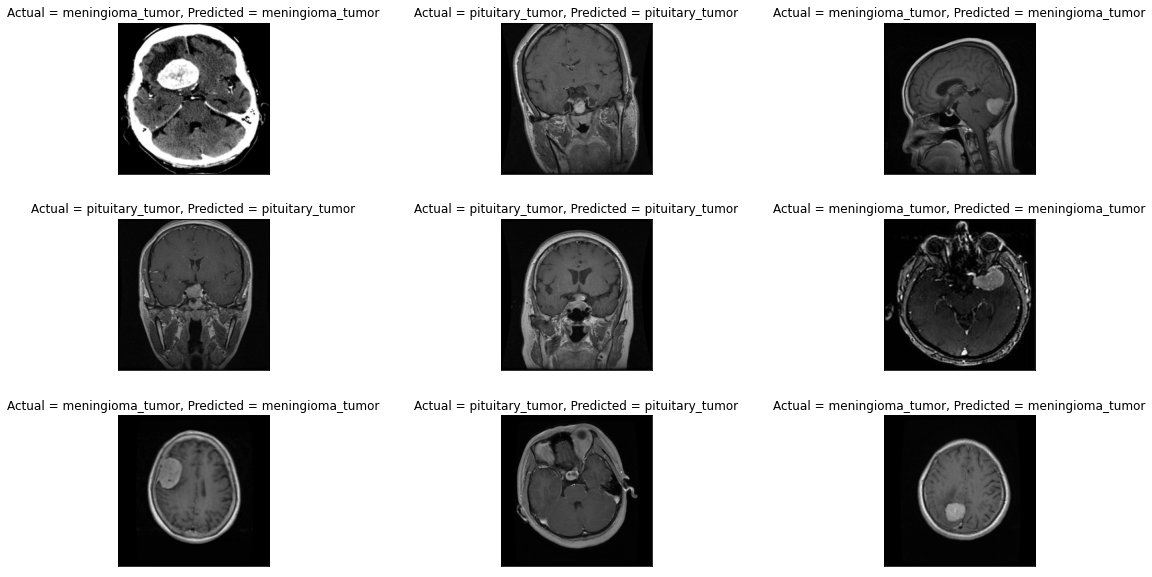

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0 
y_predict =[]
y_label_test =[]
for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    


    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(categories[y_test[r[0]]] , categories[math.ceil(y_test[r[0]]*pred[r[0]][y_test[r[0]]])]) )
    plt.xticks([]) , plt.yticks([])

plt.show()
for i in range(len(y_test)):
    #n += 1 
    #r = np.random.randint( 0, x_test.shape[0], 1)
    
    ####
    y_predict.append(y_test[i] *arr[i])
    y_label_test.append(y_test[i])

y_predict=[math.ceil(i) if i - int(i)>=0.5 else math.floor(i) for i in y_predict]

y_predict = [categories[i] for i in y_predict]
y_label_test = [categories[i] for i in y_label_test]

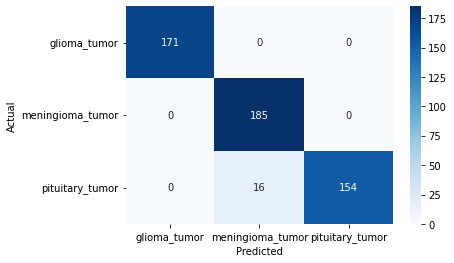

In [ ]:
out_df  = pd.DataFrame(np.vstack( [y_predict,y_label_test]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt = 'd')
plt.show()
